In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from pathlib import Path
from read_roi import read_roi_zip
from collections import OrderedDict, Counter
import math
import PIL
from PIL import Image
from PIL.TiffTags import TAGS
import tkinter as tk
from tkinter import filedialog
import seaborn as sns

# Read, format and save raw data from ROIs #

In [3]:
askdirectory = filedialog.askdirectory() # show an "Open" dialog box and return the path to the selected file
path = Path(askdirectory)
path

WindowsPath('C:/Users/Brouhard Lab/Data/Images/2022-09-07_dynamics/2022-09-07_dynamics_Ch1-tub10uM')

In [4]:
tubulin = '[Tubulin] ' r'$(\mu M)$'
tub = 'tub'

DCXconc = '[DCX] ' r'$(n M)$'
DCX = 'DCX'

investigator = 'Brandi'

In [5]:
dateloc = str(path).find("202")
date = str(path)[dateloc : dateloc+10]

folders = [x for x in path.iterdir() if x.is_dir()]
folders = [i for i in folders if (str(i)[-5:] == 'final') == True]

ch = []
conc_tub = []
conc_DCX = []
DCX_type = []

for i in folders:
    CHloc = str(i).rfind("Ch")
    tubloc = str(i).rfind(tub)
    #DCXloc = str(i).rfind(DCX)
    #dcxtype = str(i).find("type")
    ch = ch + [str(i)[CHloc+2:CHloc+3]]
    conc_tub = conc_tub + [(str(i)[tubloc+3:tubloc+5])]
    #conc_DCX = conc_DCX + [(str(i)[DCXloc+3:DCXloc+6])]
    #DCX_type = DCX_type + [(str(i)[dcxtype+4:DCXloc-1])]

date,ch, conc_tub#, conc_DCX, DCX_type


('2022-09-07', ['1'], ['10'])

In [6]:
tub_conc =  [float(i) for i in conc_tub]
#DCX_conc =  [float(i) for i in conc_DCX]
frame_analyzer = pd.read_csv(path/'frame_rates_avg.csv',sep=',')
pixel =  0.107 #T2 0.107 #T1 0.0633
folders

[WindowsPath('C:/Users/Brouhard Lab/Data/Images/2022-09-07_dynamics/2022-09-07_dynamics_Ch1-tub10uM/2022-09-07_dynamics_Ch1-tub10uM_final')]

In [7]:
#frame_analyzer = frame_analyzer.iloc[[1,3]].reset_index()
frame_analyzer

,Directory,Mean,SD,Frames,Outliers,MeanWOutliers,SDWOutliers
0,C:\Users\Brouhard Lab\Data\Images\2022-09-07_d...,5.01,0.25,405,4,12.0,127.82


In [22]:
def open_roi_poly(k,name):
    roi_path = folders[k]/(name)

    roi_data = read_roi_zip(roi_path)
    roi_df = pd.DataFrame(columns=['Track ID','x1','x2','x3','y1','y2','y3'])
    
    for key in roi_data:
        roi_df1 = pd.DataFrame({'Track ID': [roi_data[key]['name']],'x1': [roi_data[key]['x'][0]],'x2': [roi_data[key]['x'][1]],'x3': [roi_data[key]['x'][2]],'y1': [roi_data[key]['y'][0]],'y2': [roi_data[key]['y'][1]],'y3': [roi_data[key]['y'][2]]})
        roi_df = pd.concat([roi_df,roi_df1])
    
    roi_df = roi_df.reset_index(drop = True)
    return roi_df

def open_roi_line(k,name):
    roi_path = folders[k]/(name)
    roi_data = read_roi_zip(roi_path)
    roi_df = pd.DataFrame(columns=['Track ID','x1','x2','y1','y2'])
    
    for key in roi_data:
        roi_df1 = pd.DataFrame({'Track ID': [roi_data[key]['name']],'x1': [roi_data[key]['x1']],'x2': [roi_data[key]['x2']],'y1': [roi_data[key]['y1']],'y2': [roi_data[key]['y2']]})
        roi_df = pd.concat([roi_df,roi_df1])
        
    roi_df = roi_df.reset_index(drop = True)
    return roi_df


In [12]:
open_roi_poly(0,'kymoslopes.zip')

,Track ID,x1,x2,x3,y1,y2,y3
0,0096-0055,1,109,1,15,169,176
1,0124-0077,34,126,28,61,184,187
2,0115-0099,55,142,60,41,183,189
3,0151-0040,10,71,8,109,190,192
4,0059-0065,34,101,29,16,98,101
...,...,...,...,...,...,...,...
61,0158-0113,15,211,23,17,286,299
62,0127-0108,52,163,53,40,207,214
63,0080-0091,53,132,50,13,142,146
64,0101-0106,44,174,38,21,174,180


In [13]:
roi_path = folders[0]/('start.zip')
roi_data = read_roi_zip(roi_path)
roi_data

OrderedDict([('0006-0029',
              {'type': 'polyline',
               'x': [22.5, 30.5, 35.33333206176758],
               'y': [10.5, 4.666666507720947, -0.33333301544189453],
               'n': 3,
               'width': 0,
               'name': '0006-0029',
               'position': 0}),
             ('0006-0051',
              {'type': 'polyline',
               'x': [42.16666793823242, 51.833335876464844, 58.66666793823242],
               'y': [10.5, 4.333333492279053, -0.33333301544189453],
               'n': 3,
               'width': 0,
               'name': '0006-0051',
               'position': 0}),
             ('0005-0068',
              {'type': 'polyline',
               'x': [63.5, 68.0, 72.0],
               'y': [10.333333015441895,
                5.166666507720947,
                -0.16666698455810547],
               'n': 3,
               'width': 0,
               'name': '0005-0068',
               'position': 0})])

In [14]:
Length = 'Length ' r'$(\mu m)$'
Lifetime = 'Lifetime ' r'$(min)$'
GrowthRate = 'Growth Rate ' r'$(\mu m / min)$'
TimeToNucleate = 'Time to Nucleate ' r'$(min)$'
ShrinkageLength = 'Shrink Length ' r'$(\mu m)$'
ShrinkageLifetime = 'Shrink Lifetime ' r'$(min)$'
ShrinkageRate = 'Shrink Rate ' r'$(\mu m / min)$'
poly_parameter_names = (Length,Lifetime,GrowthRate,TimeToNucleate)
line_parameter_names = (Length,Lifetime,GrowthRate,TimeToNucleate,ShrinkageLength,ShrinkageLifetime,ShrinkageRate)

In [23]:
def poly_dynamics(k):
        
    data = open_roi_poly(k,'kymoslopes.zip')
    supp = open_roi_poly(k,'start.zip')
    
    spf = frame_analyzer['Mean'][k];
    frames = frame_analyzer['Frames'][k]
    
    suppn = len(supp)
    start = sum(abs(supp['y2']-supp['y1']))/suppn;
    
    n = len(data)
    pre_df = {'Date': np.full((n), date), 'Investigator': np.full((n), investigator),
              'Ch': np.full((n), ch[k]),tubulin: np.full((n), tub_conc[k])}
    df = pd.DataFrame(pre_df) 
    
    df[Length] = abs((data['x2']-data['x1'])*pixel)
    data[Lifetime] = abs((data['y2']-data['y1'])*spf/60)
    
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x['y2'] < frames else np.NaN, axis=1)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x[Lifetime] != 0 else np.NaN, axis=1)
    
    df[GrowthRate] = df[Length]/df[Lifetime]
    df[GrowthRate] = df[GrowthRate].apply(lambda x: x if x <= 5 else np.NAN )
    
    df[TimeToNucleate] = (data['y1']-start)*spf/60
    
    df[ShrinkageLength] = abs((data['x3']-data['x2'])*pixel)
    df[ShrinkageLifetime] = abs((data['y3']-data['y2'])*spf/60)
    df[ShrinkageLifetime] = df[ShrinkageLifetime].apply(lambda x: np.NAN if x == 0 else x)
    df[ShrinkageRate] = df[ShrinkageLength]/df[ShrinkageLifetime]
    
    df.loc[pd.isnull(df[GrowthRate]), 
           [Length,Lifetime,TimeToNucleate,ShrinkageLength,ShrinkageLifetime,ShrinkageRate]] = np.NaN
    
    df['Rescues'] = df[[Length,ShrinkageLength]].apply(lambda x: True if abs(x[Length]-x[ShrinkageLength]) > pixel*5 else False, axis=1)
    
    
    return df

def line_dynamics(k):
        
    data = open_roi_line(k,'kymoslope_line.zip')
    supp = open_roi_line(k,'start_line.zip')
    
    
    spf = frame_analyzer['Mean'][k];
    frames = frame_analyzer['Frames'][k]-2
    
    suppn = len(supp)
    start = sum(abs(supp['y2']-supp['y1']))/suppn;
    
    n = len(data)
    pre_df = {'Date': np.full((n), date),'Ch': np.full((n), ch[k]),'Concentration ' r'$(\mu M)$': np.full((n), tub_conc[k])}
    df = pd.DataFrame(pre_df) 
    
    
    df[Length] = abs((data['x2']-data['x1'])*pixel)
    df[Lifetime] = abs((data['y2']-data['y1'])*spf/60)
    
    df[GrowthRate] = df[Length]/df[Lifetime]
    df[GrowthRate] = df[GrowthRate].apply(lambda x: x if x <= 5 else np.NaN )
    
    data[Lifetime] = abs((data['y2']-data['y1'])*spf/60)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x['y2'] < frames else np.NaN, axis=1)
    
    df[Length] = df[GrowthRate]*df[Lifetime]
    
    df.loc[pd.isnull(df[GrowthRate]), [Length,
        Lifetime]] = np.NaN
    
    df = df[['Date','Ch','Concentration ' r'$(\mu M)$',Length,
             Lifetime,GrowthRate]]

    
    return df


In [16]:
path.parents[0],path

(WindowsPath('C:/Users/Brouhard Lab/Data/Images/2022-09-07_dynamics'),
 WindowsPath('C:/Users/Brouhard Lab/Data/Images/2022-09-07_dynamics/2022-09-07_dynamics_Ch1-tub10uM'))

In [17]:
# newdirectory = str(path.parents[0])+'//Data_Sheets'
# newmydir = Path(newdirectory)
# newmydir.mkdir(exist_ok=True)

In [18]:
df = poly_dynamics(0)
for i in range(1,len(ch)):
    df0 = poly_dynamics(i)
    df = df.append(df0, ignore_index=True)

df.to_csv(path/(investigator+'_'+date +'.csv'), encoding='utf-8', index=False)
#df.to_csv(newmydir/(investigator+'_'+date+'.csv'), encoding='utf-8', index=False)
df

,Date,Investigator,Ch,[Tubulin] $(\mu M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$,Shrink Length $(\mu m)$,Shrink Lifetime $(min)$,Shrink Rate $(\mu m / min)$,Rescues
0,2022-09-07,Brandi,1,10.0,11.556,12.8590,0.898670,0.774694,11.556,0.5845,19.770744,False
1,2022-09-07,Brandi,1,10.0,9.844,10.2705,0.958473,4.615694,10.486,0.2505,41.860279,True
2,2022-09-07,Brandi,1,10.0,9.309,11.8570,0.785106,2.945694,8.774,0.5010,17.512974,True
3,2022-09-07,Brandi,1,10.0,6.527,6.7635,0.965033,8.623694,6.741,0.1670,40.365269,False
4,2022-09-07,Brandi,1,10.0,7.169,6.8470,1.047028,0.858194,7.704,0.2505,30.754491,True
...,...,...,...,...,...,...,...,...,...,...,...,...
61,2022-09-07,Brandi,1,10.0,20.972,22.4615,0.933687,0.941694,20.116,1.0855,18.531552,True
62,2022-09-07,Brandi,1,10.0,11.877,13.9445,0.851734,2.862194,11.77,0.5845,20.136869,False
63,2022-09-07,Brandi,1,10.0,8.453,10.7715,0.784756,0.607694,8.774,0.3340,26.269461,False
64,2022-09-07,Brandi,1,10.0,13.91,12.7755,1.088803,1.275694,14.552,0.5010,29.045908,True


In [19]:
dfmean = df.groupby('Ch').mean()
dfmean.to_csv(path/(date+'_0_mean.csv'), encoding='utf-8', index=False)
dfmean

,[Tubulin] $(\mu M)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Shrink Lifetime $(min)$,Rescues
Ch,,,,,
1,10.0,9.77203,0.912641,0.45925,0.19697


In [21]:
dfstd = df.groupby('Ch').std()
dfstd.to_csv(path/(date+'_0_std.csv'), encoding='utf-8', index=False)
dfstd

,[Tubulin] $(\mu M)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Shrink Lifetime $(min)$,Rescues
Ch,,,,,
1,0.0,4.557294,0.13764,0.278507,0.400757


# Preliminary plot Histograms #

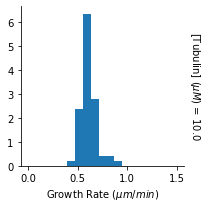

In [89]:
g = sns.FacetGrid(df, row=tubulin, margin_titles=True)
bins = np.linspace(0, 1.5, 20)
g.map(plt.hist, GrowthRate, bins=bins, density=True)

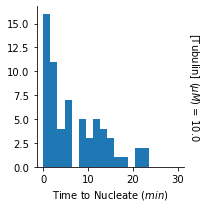

In [90]:
g = sns.FacetGrid(df, row=tubulin, margin_titles=True)
bins = np.linspace(0, 30, 20)
g.map(plt.hist, TimeToNucleate, bins=bins)

In [91]:
g = sns.FacetGrid(df, row=tubulin, col="CH", margin_titles=True)
bins = np.linspace(0, 45, 20)
g.map(plt.hist, Lifetime, bins=bins)

KeyError: 'CH'

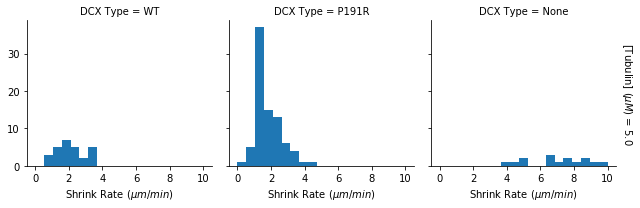

In [53]:
g = sns.FacetGrid(df, row=tubulin, col="DCX Type", margin_titles=True)
bins = np.linspace(0, 10, 20)
g.map(plt.hist, ShrinkageRate, bins=bins)